In [305]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import folium

Lectura de archivo CSV. En el archivo CSV tiene las fechas como obj, necesitamos cambiarlas a datetime.

In [192]:
link = (r"C:\Users\migue\Desktop\Proyecto BEDU\Generacion_Bruta_SIE.csv")
df = pd.read_csv(link)

df[['fecha']] = pd.to_datetime(df['fecha'])

df.head()


,fecha,bca,bcs,sin
0,2010-01-01,873193.999,146750.596,17290950.83
1,2010-02-01,793243.355,134343.163,15602656.31
2,2010-03-01,871591.088,154825.632,18255692.77
3,2010-04-01,785727.001,157132.166,18585459.93
4,2010-05-01,870490.271,174237.376,20768787.08


## Análisis Exploratorio de Datos (EDA)

En este paso revisaremos nuestros datos, como se comportan graficamente para tener un contexto más claro.

In [193]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   146 non-null    datetime64[ns]
 1   bca     146 non-null    float64       
 2   bcs     146 non-null    float64       
 3   sin     146 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 4.7 KB


,bca,bcs,sin
count,1.460000e+02,146.000000,1.460000e+02
mean,9.979682e+05,199044.687214,1.965117e+07
std,1.747548e+05,36304.176070,2.297957e+06
min,7.092862e+05,125861.119000,1.449325e+07
25%,8.654446e+05,171817.357500,1.795213e+07
50%,9.342025e+05,190254.320900,1.985295e+07
75%,1.126285e+06,222936.348000,2.175807e+07
max,1.423024e+06,310344.000000,2.344321e+07


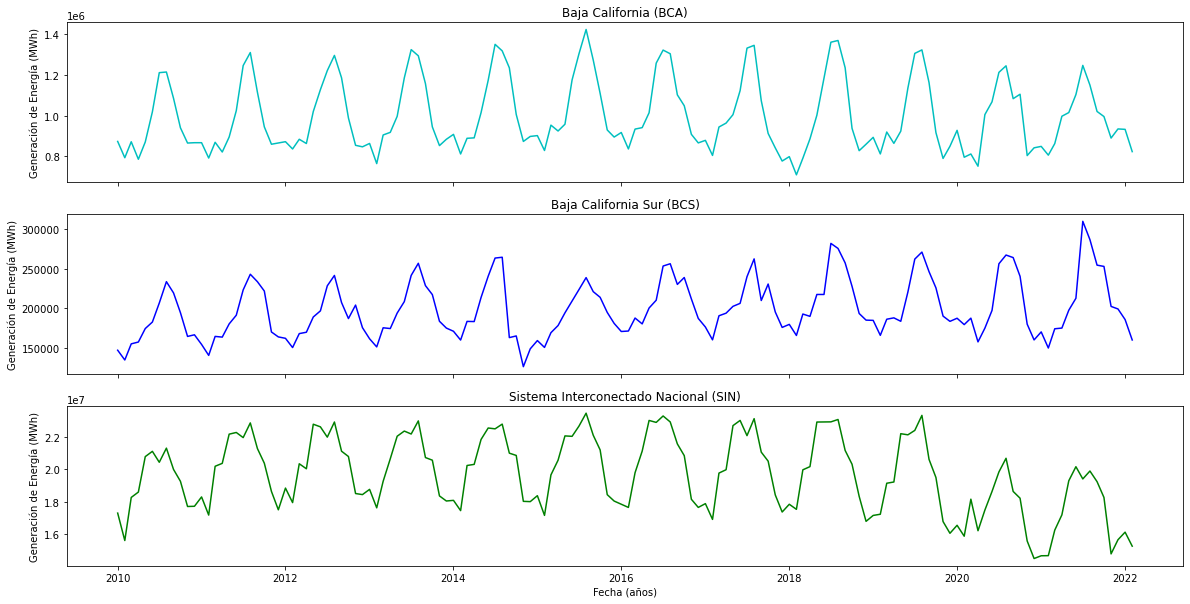

In [194]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, sharex=True,  figsize=(20,10))

#BCA
ax[0].plot(df['fecha'], 
        df['bca'], color = 'c')

ax[1].plot(df['fecha'], 
        df['bcs'], color = 'b')

ax[2].plot(df['fecha'], 
        df['sin'], color = 'g')

ax[0].set_title('Baja California (BCA)')
ax[0].set_ylabel('Generación de Energía (MWh)')

ax[1].set_title('Baja California Sur (BCS)')
ax[1].set_ylabel('Generación de Energía (MWh)')

ax[2].set_title('Sistema Interconectado Nacional (SIN)')
ax[2].set_ylabel('Generación de Energía (MWh)')
ax[2].set_xlabel('Fecha (años)')

plt.show()




In [304]:
import plotly.express as px
import requests
repo_url = 'https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json'
data_estado = pd.read_csv(r'C:\Users\migue\Desktop\Proyecto BEDU\Generacion_Bruta_SIE_Estado.csv')
mx_regions_geo = requests.get(repo_url).json()

fig = px.choropleth(data_frame=data_estado,
                    geojson=mx_regions_geo,
                    locations='estado',
                    featureidkey='properties.name',
                    color='generacion',
                    color_continuous_scale= 'Darkmint'
                    )
fig.update_geos(showcountries=True, showcoastlines=True, showland=True, fitbounds='locations')

fig.update_layout(
    title_text = 'Generación Bruta por Entidad Federativa 2010-2022 (MWh)',
    font=dict(
        family='Ubuntu',
        size=18,
        color='#7f7f7f'
    ),
    annotations = [dict(
        x=0.3,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Fuente: <a href= "https://sie.energia.gob.mx/bdiController.do?action=cuadro&subAction=applyOptions">\
        SENER </a>',
        showarrow = False
    )]
)

fig.show()



## Análisis de Regresión Lineal para Series de Tiempo.

Convertimos nuestro Dataset a una Serie.

In [195]:
def transformarSerieADataset(serie, elementosPorMuestra):
    dataset = None
    salidasDataset = None
    for counter in range (len(serie)-elementosPorMuestra-1):        
        muestra = np.array([serie[counter:counter+elementosPorMuestra]])        
        salida = np.array([serie[counter+elementosPorMuestra]])
        if dataset is None:
            dataset = muestra
        else:
            dataset = np.append(dataset,muestra,axis = 0)
        if salidasDataset is None:
            salidasDataset = salida    
        else:        
            salidasDataset = np.append(salidasDataset,salida)
    return dataset, salidasDataset

Lo convertimos a numpy array (no obligatorio, pero si un poco mas rápido en su procesamiento)

In [196]:
serie = df['bca']
serie.to_numpy()

array([ 873193.999 ,  793243.355 ,  871591.088 ,  785727.001 ,
        870490.271 , 1018504.823 , 1210946.175 , 1214077.891 ,
       1084907.635 ,  940333.298 ,  865317.36  ,  866979.811 ,
        866958.701 ,  791695.35  ,  869045.354 ,  821249.244 ,
        894858.889 , 1024233.359 , 1245806.02  , 1309745.01  ,
       1114674.112 ,  944890.923 ,  859450.862 ,  865826.2   ,
        871969.673 ,  836216.079 ,  883788.375 ,  863017.96  ,
       1019960.954 , 1127504.58  , 1220960.52  , 1295617.4   ,
       1185515.569 ,  988289.32  ,  854114.858 ,  846762.114 ,
        863321.265 ,  764320.461 ,  904909.251 ,  917783.837 ,
        996449.072 , 1185100.284 , 1324097.119 , 1293681.368 ,
       1157205.892 ,  944845.517 ,  852777.997 ,  883771.639 ,
        907941.756 ,  811641.005 ,  888584.015 ,  890763.824 ,
       1014564.89  , 1173598.469 , 1350004.285 , 1317867.124 ,
       1234712.844 , 1005710.267 ,  873184.215 ,  897789.32  ,
        901812.098 ,  828750.999 ,  953253.733 ,  92441

Empezamos a seccionar nuestro arreglo y seguimos con el entramiento de los datos para crear nuestro modelo de regresión

In [197]:
X, Y = transformarSerieADataset(serie, elementosPorMuestra=10)
print(X)

[[ 873193.999  793243.355  871591.088 ... 1214077.891 1084907.635
   940333.298]
 [ 793243.355  871591.088  785727.001 ... 1084907.635  940333.298
   865317.36 ]
 [ 871591.088  785727.001  870490.271 ...  940333.298  865317.36
   866979.811]
 ...
 [ 848838.     805857.     862664.    ... 1149805.    1020363.
   995426.   ]
 [ 805857.     862664.     996947.    ... 1020363.     995426.
   889775.   ]
 [ 862664.     996947.    1014973.    ...  995426.     889775.
   934549.   ]]


In [198]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, shuffle = False, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(81, 10)
(54, 10)
(81,)
(54,)


In [199]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

y_train_predict = lin_model.predict(X_train)
MSE = mean_squared_error(Y_train,y_train_predict)
print("Entrenamiento: MSE ="+str(MSE))

y_test_predict = lin_model.predict(X_test)
MSE = (mean_squared_error(Y_test, y_test_predict))
print("Pruebas: MSE ="+str(MSE))

Entrenamiento: MSE =4206078552.193061
Pruebas: MSE =6715715461.903146


In [200]:
df_predicciones = pd.DataFrame({'valor real':Y_test, 'prediccion':y_test_predict, 'diferencia':Y_test-y_test_predict})
df_predicciones = df_predicciones.reset_index(drop = True)
df_predicciones.head(10)

,valor real,prediccion,diferencia
0,1.345084e+06,1.321476e+06,23607.157190
1,1.073796e+06,1.222773e+06,-148976.995731
2,9.123681e+05,9.709733e+05,-58605.242203
3,8.415327e+05,8.112011e+05,30331.570442
4,7.768844e+05,7.922197e+05,-15335.355388
5,7.985164e+05,8.488553e+05,-50338.947519
6,7.092862e+05,8.770960e+05,-167809.777115
7,7.907403e+05,7.711244e+05,19615.839752
8,8.860515e+05,8.692243e+05,16827.219341
9,1.001922e+06,1.095360e+06,-93437.694912


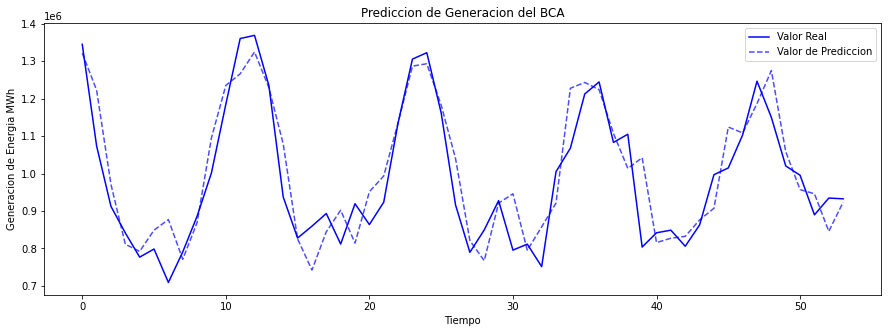

In [302]:
fig, ax = plt.subplots(figsize=(15,5))

plt.plot(df_predicciones['valor real'], label = 'Valor Real', color = 'b')
plt.plot(df_predicciones['prediccion'], label = 'Valor de Prediccion', color = 'b', alpha = 0.7, linestyle='--')

plt.title('Prediccion de Generacion del BCA')
plt.xlabel('Tiempo')
plt.ylabel('Generacion de Energia MWh')
plt.legend()
plt.show()

El modelo de regresión lineal resulto muy bueno, pero se notan algunas zonas que estan desfasadas de los datos originales.

## Regresión Polinomial

Igual que en el análisis anterior, llamamos al modelo, lo entrenamos y vemos los resultados.

In [202]:
poly_model = LinearRegression()
poly = PolynomialFeatures(degree=5)

Xpolytrain = poly.fit_transform(X_train)
Xpolytest = poly.fit_transform(X_test)

poly_model.fit(Xpolytrain, Y_train)
y_train_predict = poly_model.predict(Xpolytrain)

MSE = mean_squared_error(Y_train,y_train_predict)
print("Entrenamiento Grado = 5: MSE ="+str(MSE))

y_test_predict = poly_model.predict(Xpolytest)
MSE = (mean_squared_error(Y_test, y_test_predict))
print("Pruebas Grado = 5: MSE ="+str(MSE))




Entrenamiento Grado = 5: MSE =9.742928504012872e-18
Pruebas Grado = 5: MSE =30779924145.388336


In [203]:
df_predicciones_poly = pd.DataFrame({'valor real':Y_test, 'prediccion':y_test_predict, 'diferencia':Y_test-y_test_predict})
df_predicciones_poly = df_predicciones_poly.reset_index(drop = True)
df_predicciones_poly.head(10)


,valor real,prediccion,diferencia
0,1.345084e+06,1.273475e+06,71608.498870
1,1.073796e+06,1.209171e+06,-135374.242000
2,9.123681e+05,8.036550e+05,108713.050674
3,8.415327e+05,6.748013e+05,166731.358947
4,7.768844e+05,9.030218e+05,-126137.429380
5,7.985164e+05,8.511598e+05,-52643.403526
6,7.092862e+05,9.554816e+05,-246195.365020
7,7.907403e+05,1.016234e+06,-225493.284634
8,8.860515e+05,1.151652e+06,-265600.324055
9,1.001922e+06,1.339258e+06,-337336.124479


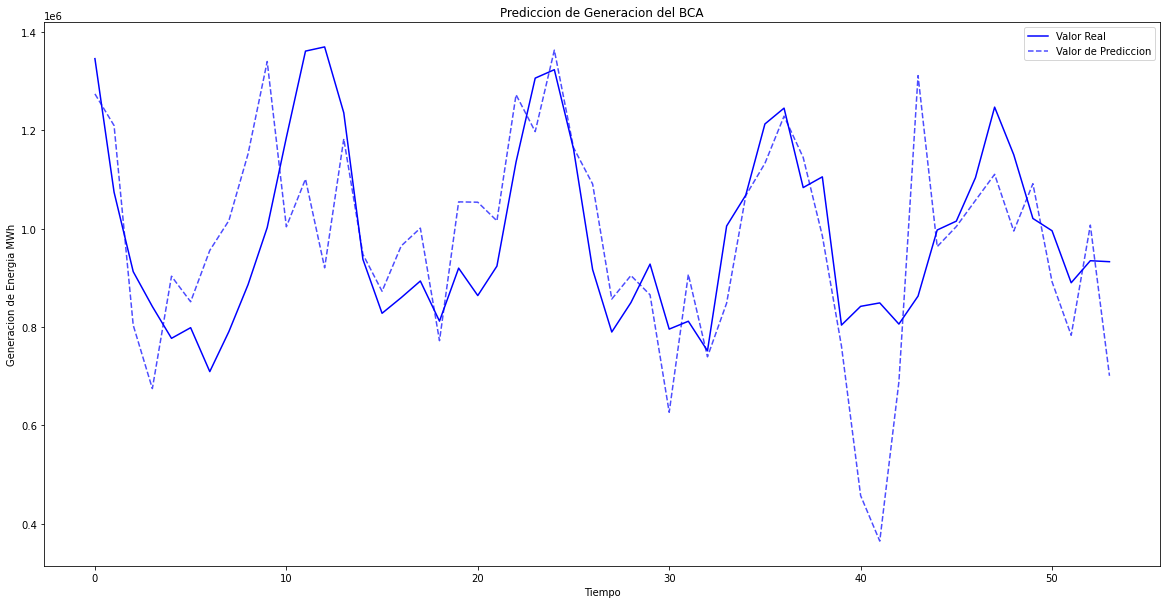

In [204]:
fig, ax = plt.subplots(figsize=(20,10))

plt.plot(df_predicciones_poly['valor real'], label = 'Valor Real', color = 'b')
plt.plot(df_predicciones_poly['prediccion'], label = 'Valor de Prediccion', color = 'b', alpha = 0.7, linestyle='--')

plt.title('Prediccion de Generacion del BCA')
plt.xlabel('Tiempo')
plt.ylabel('Generacion de Energia MWh')
plt.legend()
plt.show()


Podemos observar que aun haciendo una regresión polinomial el modelo es muy sensible a los picos que presentan los datos. La mejor opción es implementar otro modelo que se ajuste con mayor precisión.

## Implementación de modelo SARIMAX para Series de Tiempo

## SISTEMA ELECTRICO DE BAJA CALIFORNIA (BCA).
# Predicción de Generación Eléctrica


Lo primero que tenemos que hacer para implementar modelos de series de tiempo es asegurar que nuestro dataset no contenga valores nulos.

In [205]:
df.isna().sum()

fecha    0
bca      0
bcs      0
sin      0
dtype: int64

Hacemos un .describe() para ver un panorama general de la información de nuestros datos.

In [206]:
df.describe()

,bca,bcs,sin
count,1.460000e+02,146.000000,1.460000e+02
mean,9.979682e+05,199044.687214,1.965117e+07
std,1.747548e+05,36304.176070,2.297957e+06
min,7.092862e+05,125861.119000,1.449325e+07
25%,8.654446e+05,171817.357500,1.795213e+07
50%,9.342025e+05,190254.320900,1.985295e+07
75%,1.126285e+06,222936.348000,2.175807e+07
max,1.423024e+06,310344.000000,2.344321e+07


Hacemos nuestra limpieza del dataset anterior eliminando las columnas que no necesitamos (este paso lo repetiremos posteriormente para el BCS y el SIN) con fecha como index.

In [207]:
df_bca = df.drop(columns = ['sin', 'bcs'])
df_bca.set_index(df_bca['fecha'], inplace=True)
df_bca.drop(columns='fecha', inplace=True)
df_bca.head()

,bca
fecha,
2010-01-01,873193.999
2010-02-01,793243.355
2010-03-01,871591.088
2010-04-01,785727.001
2010-05-01,870490.271


Empezamos con una descomposicion del comportamiento de los datos con respecto al tiempo, en este caso, los datos se comportan con una estacionalidad muy caracteristica, esto debido a que sabemos que entre mayor es la temperatura (verano), la demanda de energía es mayor, por lo tanto la generación de energía tambien es mayor. 
Se puede decir que la generación es directamente proporcional a la demanda, y viceversa.


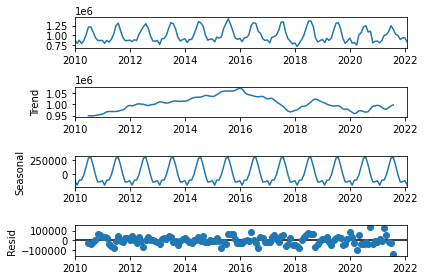

In [208]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data_bca = seasonal_decompose(df_bca, model="additive")
decompose_data_bca.plot();

<AxesSubplot:xlabel='fecha'>

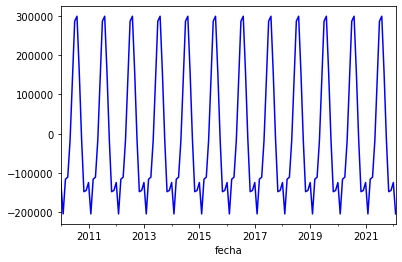

In [209]:
## Graficamos la estacionalidad de nuestros datos.
seasonality_bca=decompose_data_bca.seasonal
seasonality_bca.plot(color='blue')

In [210]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_bca.bca, autolag = 'AIC')
print("1. ADF : ", dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.9535839594319149
2. P-Value :  0.30728813777795383
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 133
5. Critical Values :
	 1% :  -3.480500383888377
	 5% :  -2.8835279559405045
	 10% :  -2.578495716547007


<ipython-input-211-367182f74a73>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot()


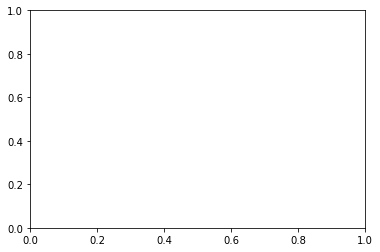

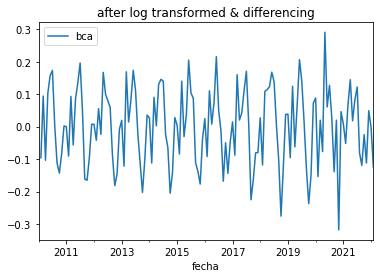

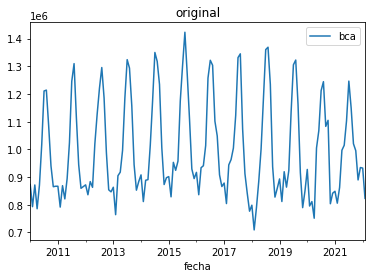

In [211]:
 log_bca = pd.DataFrame(df_bca.bca.apply(lambda x : np.log(x)))
 log_diff_bca = log_bca - log_bca.shift()
 ax1 = plt.subplot()
 log_diff_bca.plot(title='after log transformed & differencing');
 ax2 = plt.subplot()
 df_bca.plot(title='original'); 

In [212]:
 from statsmodels.tsa.stattools import adfuller
 test = adfuller(log_diff_bca.dropna().bca)
 print("p-value :", test[1]) 

p-value : 4.929947567609802e-11


In [213]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df_bca['bca'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<AxesSubplot:xlabel='fecha'>

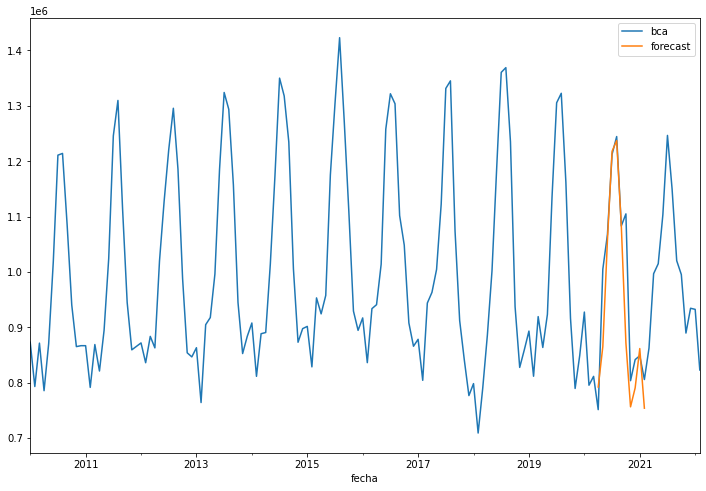

In [214]:
df_bca['forecast']=results.predict(start=123,end=133,dynamic=True)
df_bca[['bca', 'forecast']].plot(figsize=(12,8))

Se puede notar que la implementación del modelo SARIMAX se ajusta muy bien a los datos reales, las lineas de 'forecast' y 'bca' estan practicamente sobrepuestas. 
Lo siguiente es hacer un DataFrame con fechas posteriores a las que tenemos en nuestro dataset, para ajustar los resultados de nuestro modelo a estas fechas.

In [215]:
from pandas.tseries.offsets import DateOffset
pred_date=[df_bca.index[-1]+ DateOffset(months=x)for x in range(0,24)]

pred_date=pd.DataFrame(index=pred_date[1:],columns=df_bca.columns)
pred_date.head()

,bca,forecast
2022-03-01,NaN,NaN
2022-04-01,NaN,NaN
2022-05-01,NaN,NaN
2022-06-01,NaN,NaN
2022-07-01,NaN,NaN


Hacemos un .concat() para unir nuestros DataFrames.

In [216]:
df_bca_=pd.concat([df_bca,pred_date])
df_bca_.head()

,bca,forecast
2010-01-01,873193.999,NaN
2010-02-01,793243.355,NaN
2010-03-01,871591.088,NaN
2010-04-01,785727.001,NaN
2010-05-01,870490.271,NaN


Graficamos nuestro nuevo dataset volviendo a hacer .predict() ajustando el start y end para que se ajuste a las fechas nuevas de predicción.

<AxesSubplot:>

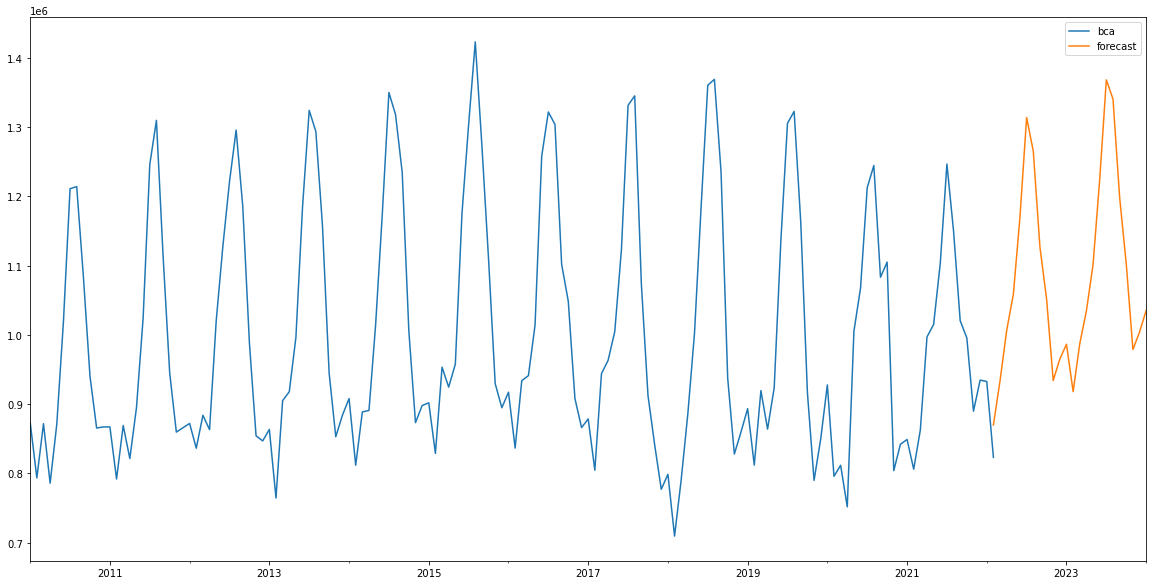

In [217]:
df_bca_['forecast'] = results.predict(start = 145, end = 168, dynamic= True)  
df_bca_
df_bca_[['bca','forecast']].plot(figsize=(20,10))

## SISTEMA ELECTRICO DE BAJA CALIFORNIA SUR (BCS)
# Predicción de Generación Eléctrica

Repetimos los pasos anteriores.

In [218]:
df_bcs = df.drop(columns = ['sin', 'bca'])
df_bcs.set_index(df_bcs['fecha'], inplace=True)
df_bcs.drop(columns='fecha', inplace=True)
df_bcs.head()

,bcs
fecha,
2010-01-01,146750.596
2010-02-01,134343.163
2010-03-01,154825.632
2010-04-01,157132.166
2010-05-01,174237.376


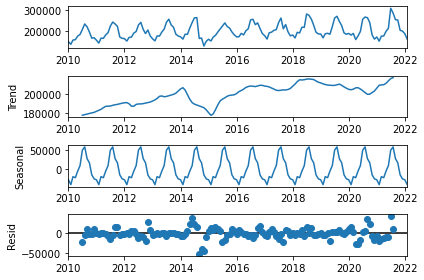

In [219]:
decompose_data_bcs = seasonal_decompose(df_bcs, model="additive")
decompose_data_bcs.plot();

<AxesSubplot:xlabel='fecha'>

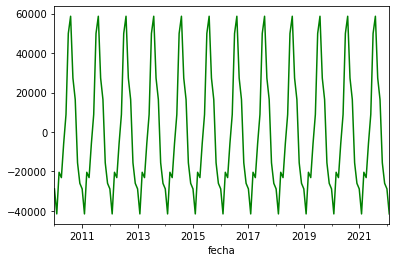

In [220]:
seasonality_bcs=decompose_data_bcs.seasonal
seasonality_bcs.plot(color='green')

<ipython-input-221-520504f50a79>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot()


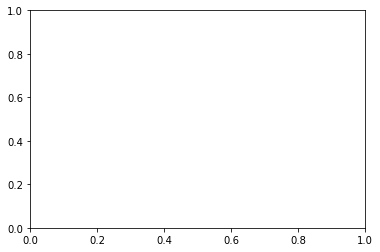

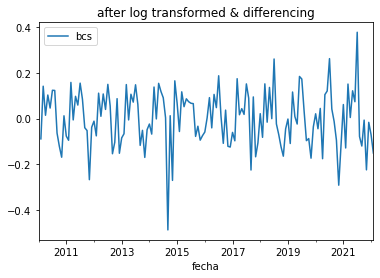

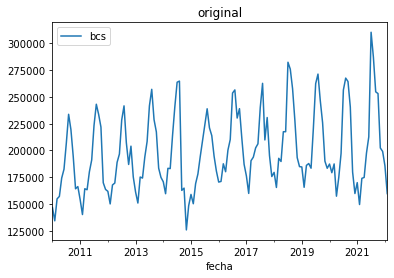

In [221]:
 log_bcs = pd.DataFrame(df_bcs.bcs.apply(lambda x : np.log(x)))
 log_diff_bcs = log_bcs - log_bcs.shift()
 ax1 = plt.subplot()
 log_diff_bcs.plot(title='after log transformed & differencing');
 ax2 = plt.subplot()
 df_bcs.plot(title='original'); 

In [222]:
 test_bcs = adfuller(log_diff_bcs.dropna().bcs)
 print("p-value :", test_bcs[1]) 

p-value : 3.142869995108454e-07


In [223]:
model=sm.tsa.statespace.SARIMAX(df_bcs['bcs'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='fecha'>

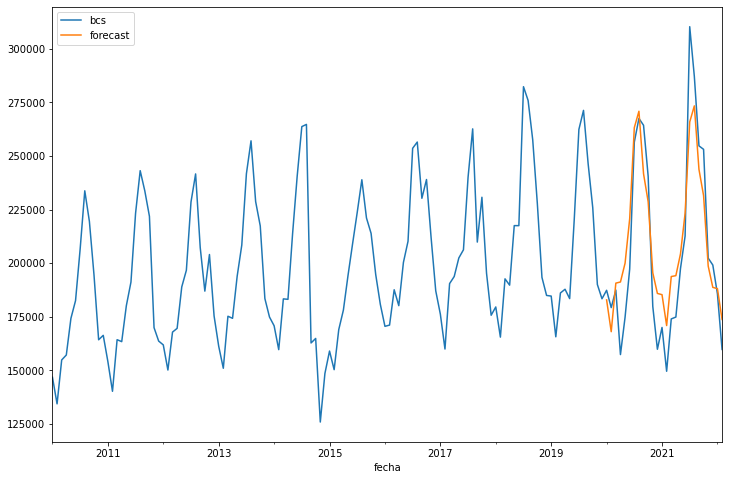

In [224]:
df_bcs['forecast']=results.predict(start=120,end=146,dynamic=True)
df_bcs[['bcs', 'forecast']].plot(figsize=(12,8))

In [225]:
from pandas.tseries.offsets import DateOffset
pred_date_bcs=[df_bca.index[-1]+ DateOffset(months=x)for x in range(0,24)]

pred_date_bcs=pd.DataFrame(index=pred_date_bcs[1:],columns=df_bcs.columns)
pred_date_bcs.head()

,bcs,forecast
2022-03-01,NaN,NaN
2022-04-01,NaN,NaN
2022-05-01,NaN,NaN
2022-06-01,NaN,NaN
2022-07-01,NaN,NaN


In [226]:
df_bcs_=pd.concat([df_bcs,pred_date_bcs])
df_bcs_.head()

,bcs,forecast
2010-01-01,146750.596,NaN
2010-02-01,134343.163,NaN
2010-03-01,154825.632,NaN
2010-04-01,157132.166,NaN
2010-05-01,174237.376,NaN


<AxesSubplot:>

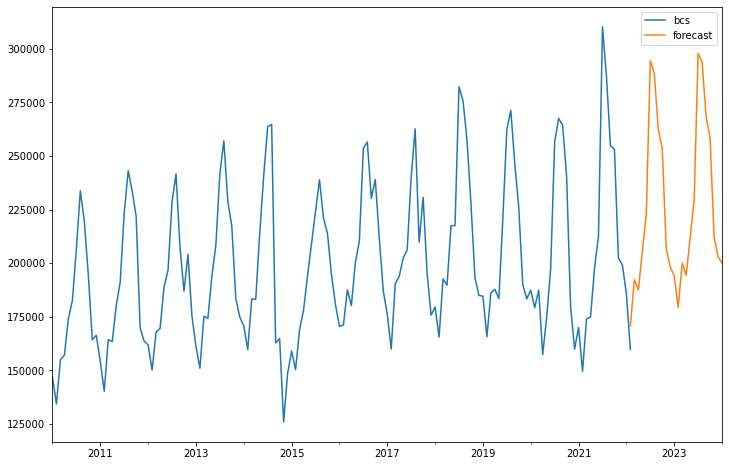

In [227]:
df_bcs_['forecast'] = results.predict(start = 145, end = 168, dynamic= True)  
df_bcs_[['bcs','forecast']].plot(figsize=(12,8))

## SISTEMA INTERCONECTADO NACIONAL (SIN)
# Predicción de Generación Eléctrica

In [228]:
df_sin = df.drop(columns = ['bca', 'bcs'])
df_sin = df_sin.set_index(['fecha'])
df_sin.head()

,sin
fecha,
2010-01-01,17290950.83
2010-02-01,15602656.31
2010-03-01,18255692.77
2010-04-01,18585459.93
2010-05-01,20768787.08


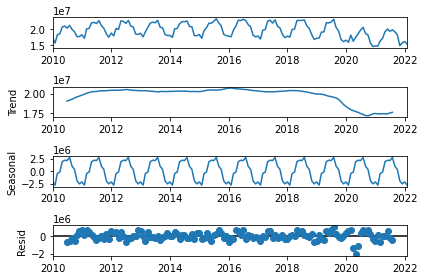

In [229]:
decompose_data_sin = seasonal_decompose(df_sin, model="additive")
decompose_data_sin.plot();

<AxesSubplot:xlabel='fecha'>

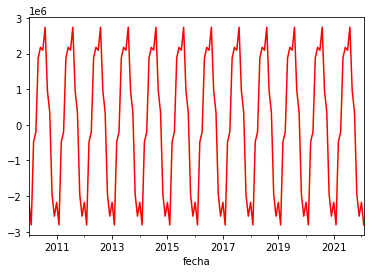

In [230]:
seasonality_sin=decompose_data_sin.seasonal
seasonality_sin.plot(color='red')

<ipython-input-231-7e818c6f66bb>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot()


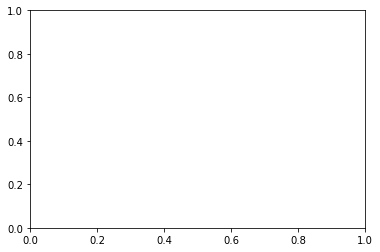

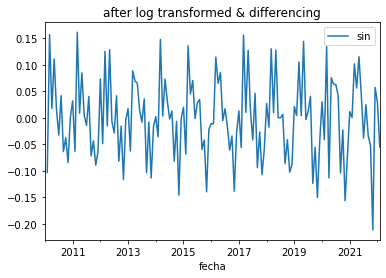

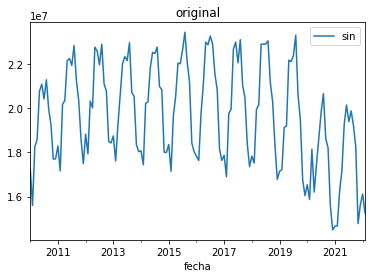

In [231]:
 log_sin = pd.DataFrame(df_sin.sin.apply(lambda x : np.log(x)))
 log_diff_sin = log_sin - log_sin.shift()
 ax1 = plt.subplot()
 log_diff_sin.plot(title='after log transformed & differencing');
 ax2 = plt.subplot()
 df_sin.plot(title='original'); 

In [232]:
 test_sin = adfuller(log_diff_sin.dropna().sin)
 print("p-value :", test_sin[1]) 

p-value : 0.02903277497702348


In [233]:
model=sm.tsa.statespace.SARIMAX(df_sin['sin'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\Users\migue\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='fecha'>

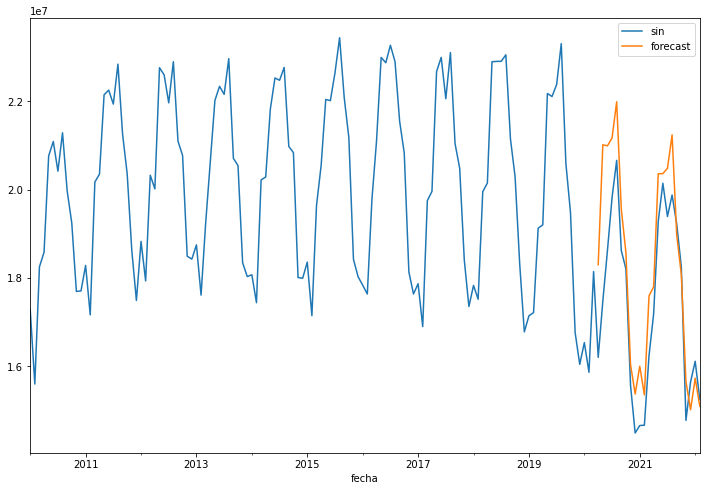

In [234]:
df_sin['forecast']=results.predict(start=123,end=145,dynamic=True)
df_sin[['sin', 'forecast']].plot(figsize=(12,8))

In [235]:
pred_date_sin=[df_sin.index[-1]+ DateOffset(months=x)for x in range(0,24)]

pred_date_sin=pd.DataFrame(index=pred_date_sin[1:],columns=df_sin.columns)
pred_date_sin.head()

,sin,forecast
2022-03-01,NaN,NaN
2022-04-01,NaN,NaN
2022-05-01,NaN,NaN
2022-06-01,NaN,NaN
2022-07-01,NaN,NaN


In [236]:
df_sin_=pd.concat([df_sin,pred_date_sin])
df_sin_.head()

,sin,forecast
2010-01-01,17290950.83,NaN
2010-02-01,15602656.31,NaN
2010-03-01,18255692.77,NaN
2010-04-01,18585459.93,NaN
2010-05-01,20768787.08,NaN


<AxesSubplot:>

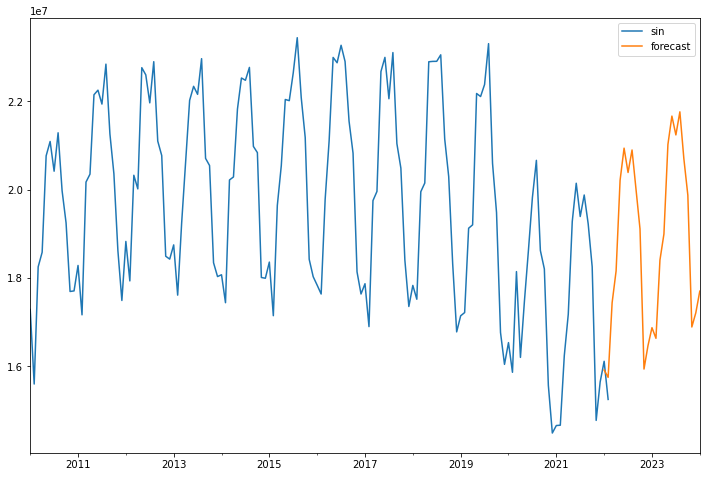

In [239]:
df_sin_['forecast'] = results.predict(start = 144, end = 168, dynamic= True)  
df_sin_[['sin','forecast']].plot(figsize=(12,8))